#### Иерархические модели

Предположим, что необходимо проанализировать качество воды в некотором городе, поэтому мы используем выборки на основе разделения городской территории на смежные районы.

* С одной стороны, можно проанализировать каждый район по отдельности для полноты картины.
* С дргугой стороны, можно набрать крупную выборку данных со всех районов для общей оценки.

Иерархические модели в данном контексте позволяют выбрать промежуточное решение, которое оценивает качество воды и по районам и по всему городу в целом.

Т.е. вместо жесткого определения параметров априорных распределений как некоторых постоянных чисел выполняется их оценка непосредственно по исследуемым данным посредством размещения совместно используемых априорных распределений для всех параметров.

При этом модель такая модель быстро становится трудной для понимания, и если задача не требует более глубокой структуры, то добавление избыточных уровней не поможет улучшить качество статистических выводов.

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext watermark
%watermark --iversions

pymc3     : 3.10.0
arviz     : 0.11.1
pandas    : 1.1.4
matplotlib: 3.4.2
scipy     : 1.5.2
seaborn   : 0.10.0
numpy     : 1.19.2



#### Описание данных

Данные для примера искусственные. Предположим, что уже собраны образцы воды из трех различных районов города и измерено содержание свинца
в этих образцах. Образцы с содержанием свинца, превышающим концентрацию, рекомендованную ВОЗ, помечаются нулем, а образцы с нормальным содержанием свинца помечаются единицей.

In [3]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [4]:
group_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

Модель:


$$\mu \sim Beta(\alpha_\mu, \beta_\mu);$$
$$k \sim |Normal(0, \sigma_k)|;$$
$$\alpha=\mu * k;$$
$$\beta=(1-\mu)*k;$$
$$\theta_i \sim Beta(\alpha_i, \beta_i);$$
$$y \sim Bern(\theta_i).$$

Отметим, что $\alpha$, $\beta$ - детерминированные параметры, так как при известных $\mu, k$ они могут быть одназначно определены. Остальные параметры остаются стохастическими.

In [5]:
with pm.Model() as model_h:
    mu = pm.Beta('mu', 1.0, 1.0)
    k = pm.HalfNormal('k', 10)
    
    theta = pm.Beta('theta', alpha=mu*k, beta=(1-mu)*k, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)
    
    trace_h = pm.sample(2000)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, k, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


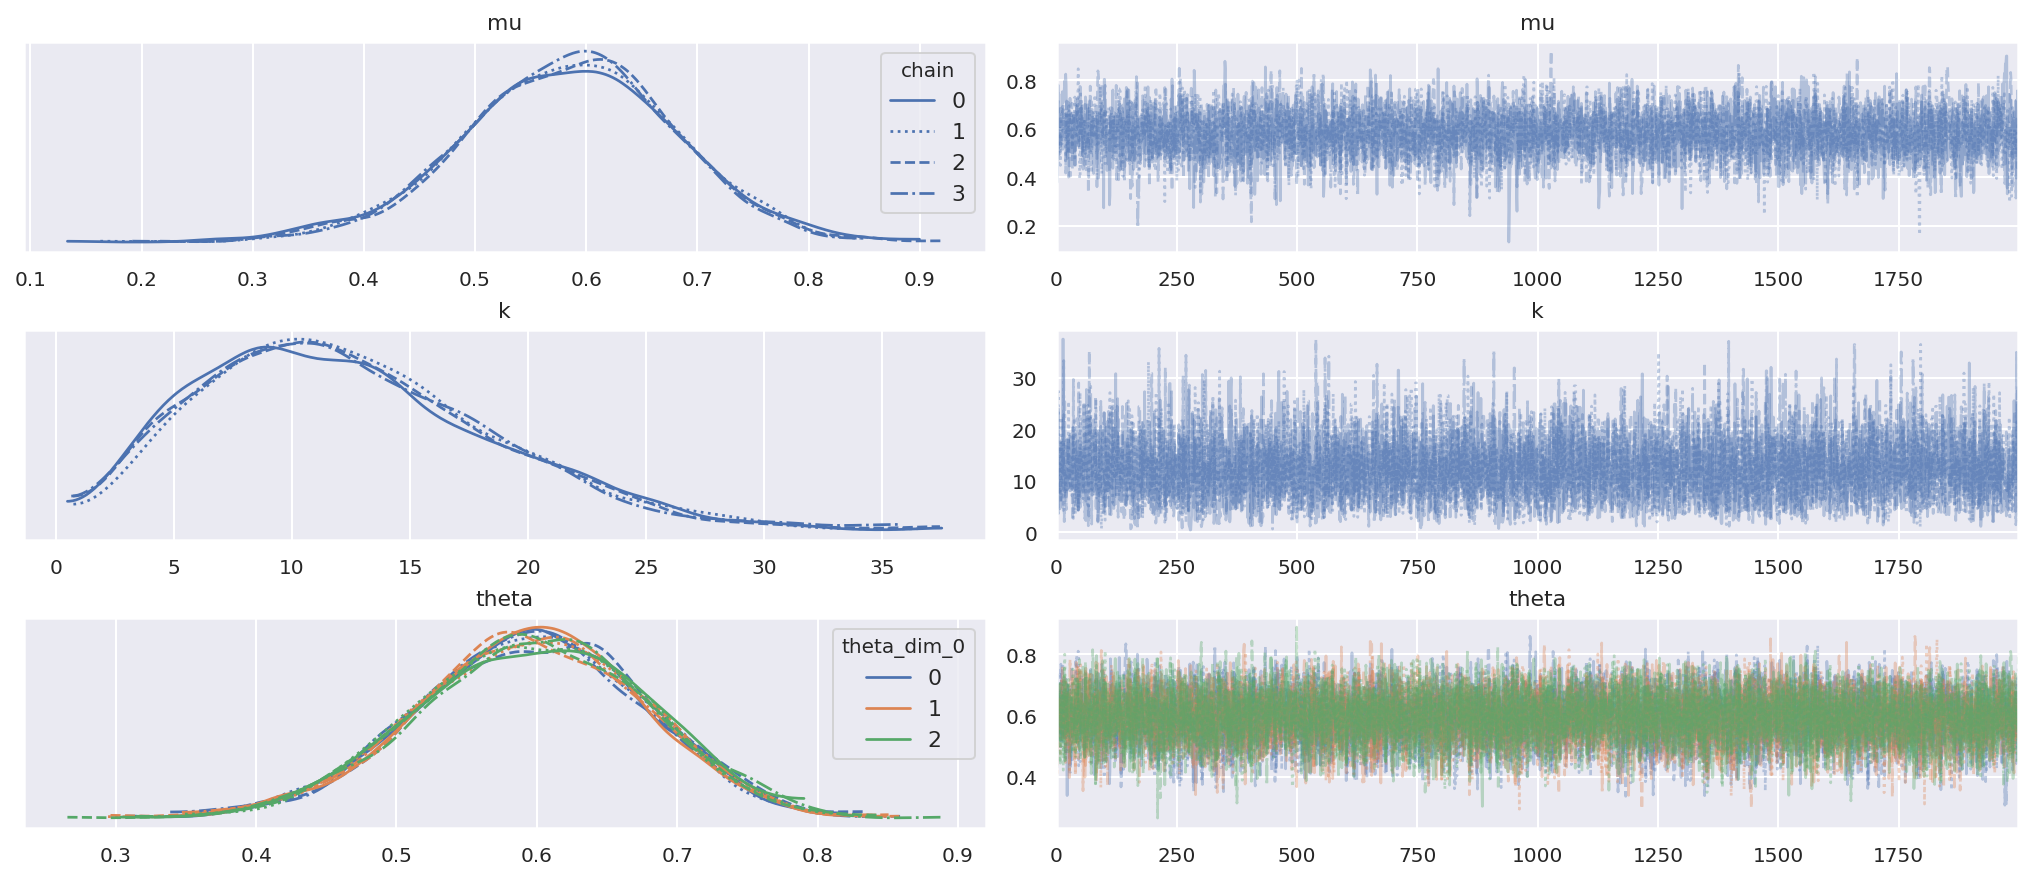

In [6]:
az.plot_trace(trace_h, figsize=(14, 6), legend=True)
plt.show()

Оставим результаты первого прогона и сформируем результаты трех экспериментов:

* G_samples - все 18
* G_samples - все 3
* G_samples - одна группа 18, остальные 3

In [14]:
df_exp0 = az.summary(trace_h)
df_exp0

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.584,0.095,0.417,0.777,0.001,0.001,4814.0,4680.0,4784.0,4588.0,1.0
k,12.345,6.132,1.957,23.314,0.078,0.055,6259.0,6259.0,5671.0,3685.0,1.0
theta[0],0.595,0.080,0.450,0.749,0.001,0.001,5096.0,4972.0,5037.0,5171.0,1.0
theta[1],0.595,0.080,0.448,0.750,0.001,0.001,5237.0,5222.0,5267.0,5527.0,1.0
theta[2],0.597,0.081,0.445,0.747,0.001,0.001,5747.0,5733.0,5772.0,5291.0,1.0


In [9]:
def sample_model_h(data, group_idx, n_samples):
    with pm.Model() as model_h:
        mu = pm.Beta('mu', 1.0, 1.0)
        k = pm.HalfNormal('k', 10)
    
        theta = pm.Beta('theta', alpha=mu*k, beta=(1-mu)*k, shape=len(n_samples))
        y = pm.Bernoulli('y', p=theta[group_idx], observed=data)
    
        trace_h = pm.sample(2000)
    return trace_h

In [10]:
experiments = {'exp0': [18, 18, 18],
               'exp1': [3, 3, 3],
               'exp2': [18, 3, 3]
              }
summaries = {}

N_samples = [30, 30, 30]

for exp_name, G_samples in experiments.items():
    
    group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
    data = []
    for i in range(0, len(N_samples)):
        data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
        
    trace = sample_model_h(data=data, group_idx=group_idx, n_samples=N_samples)
    summaries.update({exp_name: trace})

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, k, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, k, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, k, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [15]:
az.summary(summaries['exp0'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.585,0.096,0.398,0.760,0.001,0.001,4676.0,4647.0,4668.0,5583.0,1.0
k,12.313,6.105,1.626,23.230,0.083,0.059,5417.0,5417.0,5095.0,4626.0,1.0
theta[0],0.597,0.080,0.447,0.749,0.001,0.001,5177.0,5134.0,5161.0,5272.0,1.0
theta[1],0.597,0.079,0.457,0.750,0.001,0.001,5755.0,5686.0,5740.0,6023.0,1.0
theta[2],0.597,0.080,0.456,0.752,0.001,0.001,5245.0,5245.0,5246.0,5116.0,1.0


In [16]:
az.summary(summaries['exp1'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.163,0.074,0.046,0.299,0.001,0.001,4098.0,4042.0,4266.0,4877.0,1.0
k,11.860,6.243,1.252,22.998,0.088,0.062,5043.0,5043.0,4492.0,3480.0,1.0
theta[0],0.114,0.052,0.029,0.211,0.001,0.000,6122.0,6122.0,5890.0,5081.0,1.0
theta[1],0.115,0.052,0.030,0.215,0.001,0.001,5399.0,5399.0,5189.0,4596.0,1.0
theta[2],0.115,0.053,0.025,0.216,0.001,0.001,5327.0,5327.0,4869.0,4076.0,1.0


In [17]:
az.summary(summaries['exp2'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.299,0.115,0.109,0.525,0.002,0.001,4778.0,4569.0,4761.0,4774.0,1.0
k,5.912,3.937,0.572,13.356,0.059,0.042,4511.0,4486.0,4486.0,4138.0,1.0
theta[0],0.550,0.089,0.383,0.713,0.001,0.001,5293.0,5293.0,5304.0,5149.0,1.0
theta[1],0.129,0.059,0.029,0.238,0.001,0.001,6138.0,6138.0,5784.0,4487.0,1.0
theta[2],0.128,0.058,0.024,0.231,0.001,0.001,5613.0,5590.0,5404.0,4696.0,1.0


Вместо получения комбинации оценок $\theta$ по первым двум экспериментам, по третьему эксперименту значения $\theta$ сталии менее экстремальными. В целом это называют эффектом __редуцирования__ (__shrinkage__). Данный эффект свойственен иерархическим моделям.


Эффект редуцирования вносит определенный вклад в получение более стабильных статистических выводов. Это во многом
похоже на то, что можно наблюдать при использовании t-распределения Стьюдента для обработки промахов, где применяются результаты распределения с медленно убывающими хвостами в модели, более устойчивой
или менее чувствительной к наличию точек данных, расположенных далеко от среднего значения.

Размер эффекта редуцирования зависит от данных: группа с большим объемом данных будет сильнее влиять на оценку других групп, чем группа с меньшим количеством точек данных. Если несколько групп одинаковы, а одна группа отличается от них, то одинаковые группы будут информировать друг друга о своей одинаковости и подкреплять общую оценку.

Также  эффективно использовать информативное априорное гиперраспределение для редуцирования оценки до некоторого разумного значения, если имеется заслуживающая доверия информация о распределении на уровне групп.

Форма оцененного  априорного распределения:

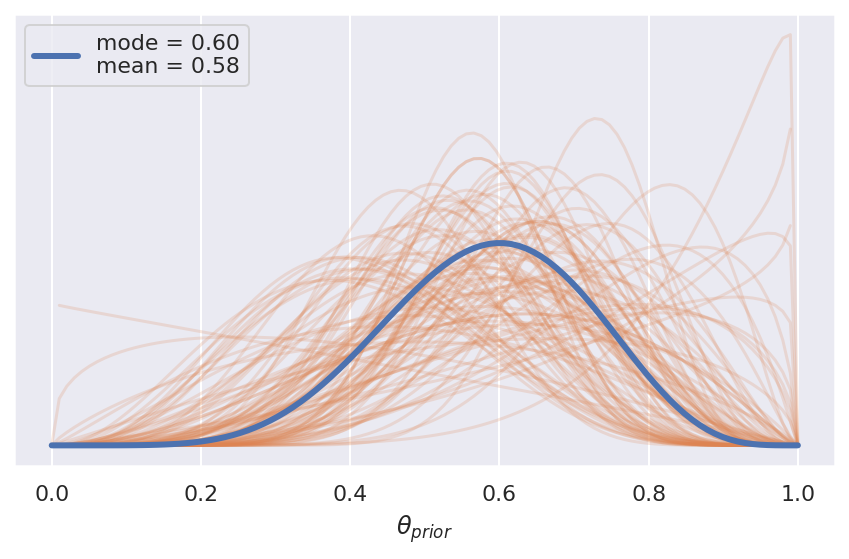

In [21]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['mu'][i]
    k = trace_h['k'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf, 'C1', alpha=0.2)
    
u_mean = trace_h['mu'].mean()
k_mean = trace_h['k'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)

pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])
plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()